In [ ]:
LIMITATIONS ADDRESSED:
━━━━━━━━━━��━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. SMALL DATASET (N=108)
   ✓ Solution: 5-Fold Stratified K-Fold Cross-Validation
   ✓ Benefit: Maximizes training data usage, reduces variance

2. EXTREME CLASS IMBALANCE
   ✓ Solution: Class-weighted loss (S0:1.2, S1:2.5, S2:4.0, S3:1.0)
   ✓ Benefit: Forces model to learn minority classes
   ✓ Solution: Label smoothing (0.1) - Prevents overconfidence
   ✓ Solution: Stratified splits - Maintains class distribution

3. OVERFITTING RISK
   ✓ Solution: Selective unfreezing of backbone layers
   ✓ Solution: Strong data augmentation (flips, rotations, color jitter)
   ✓ Solution: Dropout layers (0.5) in classifier
   ✓ Solution: Batch normalization for stability
   ✓ Solution: Early stopping with patience=15

4. POOR MINORITY CLASS DETECTION
   ✓ Solution: 4x Test-Time Augmentation (TTA)
   ✓ Solution: 5-Fold Ensemble with Soft Voting
   ✓ Solution: Weighted loss emphasizing S1, S2

5. LACK OF INTERPRETABILITY
   ✓ Solution: Consensus Analysis - Models must agree for deployment
   ✓ Benefit: 4/5 agreement achieves ~71% accuracy
   ✓ Solution: Confidence scores from ensemble averaging

6. UNSTABLE TRAINING
   ✓ Solution: CosineAnnealingWarmRestarts scheduler
   ✓ Solution: Gradient clipping (max_norm=1.0)
   ✓ Solution: AdamW optimizer with weight decay=0.01
   ✓ Solution: Learning rate warmup

KEY IMPROVEMENTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Multi-fold validation reduces overfitting
✓ Ensemble averaging improves robustness
✓ Class weighting improves recall on rare classes
✓ TTA provides additional variance reduction
✓ Consensus analysis enables selective deployment
✓ Advanced scheduling improves convergence
✓ Better data augmentation aids generalization

EXPECTED PERFORMANCE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Overall Accuracy: ~55-65% (from single models)
With 4/5 Consensus: ~70-75% (high confidence predictions only)
S0 Recall: ~80-90% (good detection of normal)
S1/S2 Recall: ~40-60% (improved with weighting)
S3 Recall: ~60-80% (good detection of cirrhosis)

DEPLOYMENT STRATEGY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Only deploy predictions where 4+ models agree
2. Flag uncertain cases (< 3 model agreement) for physician review
3. Use confidence scores to prioritize urgent cases
4. Monitor performance on external validation set
5. Retrain with additional data when available

In [ ]:
# ============================================================
# FULL JUPYTER NOTEBOOK: PANCREATIC FIBROSIS CLASSIFICATION
# ============================================================

# Install required packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1. CONFIGURATION
# ============================================================
DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8
BATCH_SIZE = 4
EPOCHS = 100
PATIENCE = 15
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Using device: {DEVICE}")
print(f"Data path exists: {os.path.exists(DATA_PATH)}\n")

# ============================================================
# 2. DATASET CLASS
# ============================================================
class PancreasDataset(Dataset):
    """Dataset for loading pancreatic ultrasound scan sequences"""
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        # Load image names
        img_names = sorted([
            f for f in os.listdir(path) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        
        # Select frames
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            # Random sampling for training
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            # Uniform sampling for validation/test
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        # Load and transform images
        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
        
        # Pad sequence to MAX_SEQ_LENGTH
        while len(sequence) < MAX_SEQ_LENGTH:
            if len(sequence) > 0:
                padding = torch.zeros_like(sequence[0])
            else:
                padding = torch.zeros(3, 224, 224)
            sequence.append(padding)
        
        return torch.stack(sequence), torch.tensor(label, dtype=torch.long)

# ============================================================
# 3. MODEL ARCHITECTURE
# ============================================================
class PancreasTransformer(nn.Module):
    """
    EfficientNet-B0 backbone + Transformer encoder + Classifier head
    for multi-class pancreatic stage classification
    """
    def __init__(self, num_classes=4):
        super().__init__()
        
        # Load pre-trained EfficientNet backbone
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Selective unfreezing: freeze early layers, unfreeze final blocks
        for param in backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze final blocks for medical image adaptation
        for name, param in backbone.named_parameters():
            if "blocks.6" in name or "blocks.7" in name or "head" in name:
                param.requires_grad = True
        
        # Feature extraction (remove classification head)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        self.feature_dim = 1280
        
        # Transformer for temporal modeling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.feature_dim,
            nhead=4,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=1
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """
        x: (batch_size, seq_length, 3, 224, 224)
        returns: (batch_size, num_classes)
        """
        batch_size, seq_len, c, h, w = x.shape
        
        # Reshape for backbone processing
        x = x.view(batch_size * seq_len, c, h, w)
        
        # Extract features
        features = self.feature_extractor(x)
        features = features.view(batch_size, seq_len, -1)
        
        # Transformer encoding
        transformer_out = self.transformer(features)
        
        # Global average pooling
        pooled = torch.mean(transformer_out, dim=1)
        
        # Classification
        logits = self.classifier(pooled)
        return logits

# ============================================================
# 4. DATA PREPARATION
# ============================================================
def prepare_data():
    """Load and prepare data for K-fold cross-validation"""
    all_paths = []
    all_labels = []
    
    for i, cls in enumerate(CLASSES):
        cls_dir = os.path.join(DATA_PATH, cls)
        if os.path.exists(cls_dir):
            folders = os.listdir(cls_dir)
            for p_folder in folders:
                all_paths.append(os.path.join(cls_dir, p_folder))
                all_labels.append(i)
    
    all_paths = np.array(all_paths)
    all_labels = np.array(all_labels)
    
    print(f"{'='*60}")
    print(f"Dataset Summary -> Total: {len(all_paths)} | Classes: {np.bincount(all_labels)}")
    print(f"{'='*60}\n")
    
    return all_paths, all_labels

# ============================================================
# 5. TRAINING FUNCTION
# ============================================================
def train_fold(model, train_loader, val_loader, fold_num, class_weights):
    """Train model on a single fold"""
    
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-5
    )
    
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    
    # FIX: Remove 'verbose' parameter
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    best_val_loss = float('inf')
    no_improve = 0
    best_state = None
    
    for epoch in range(1, EPOCHS + 1):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, lbls)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(logits.data, 1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                
                logits = model(imgs)
                loss = criterion(logits, lbls)
                val_loss += loss.item()
                
                _, preds = torch.max(logits.data, 1)
                val_correct += (preds == lbls).sum().item()
                val_total += lbls.size(0)
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        scheduler.step(val_loss)
        
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.1f}% | Val Acc: {val_acc:.1f}%")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            best_state = model.state_dict().copy()
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_state)
                break
    
    return best_val_loss

# ============================================================
# 6. MAIN K-FOLD TRAINING LOOP
# ============================================================
def main():
    # Load data
    all_paths, all_labels = prepare_data()
    
    # Calculate class weights
    class_counts = np.bincount(all_labels)
    class_weights = torch.tensor(
        [1.0 / count for count in class_counts],
        dtype=torch.float32
    ).to(DEVICE)
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    
    print(f"Class weights: {class_weights.cpu().numpy()}\n")
    
    # K-Fold setup
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    
    # Augmentations
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    print(f"Starting 5-Fold Cross-Validation Training...")
    print(f"{'='*60}\n")
    
    fold_results = []
    all_preds = []
    all_true = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels), 1):
        print(f"\n{'='*60}")
        print(f"FOLD {fold}/{FOLDS}")
        print(f"{'='*60}")
        
        train_paths = all_paths[train_idx]
        train_labels = all_labels[train_idx]
        val_paths = all_paths[val_idx]
        val_labels = all_labels[val_idx]
        
        print(f"Train: {len(train_paths)} | Val: {len(val_paths)}")
        print(f"Class distribution (train): {np.bincount(train_labels)}")
        print(f"Class distribution (val): {np.bincount(val_labels)}")
        
        # Data loaders
        train_dataset = PancreasDataset(train_paths, train_labels, train_transforms, is_train=True)
        val_dataset = PancreasDataset(val_paths, val_labels, val_transforms, is_train=False)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Model
        model = PancreasTransformer(num_classes=len(CLASSES)).to(DEVICE)
        
        # Train
        best_loss = train_fold(model, train_loader, val_loader, fold, class_weights)
        fold_results.append(best_loss)
        
        # Validation predictions
        model.eval()
        fold_preds = []
        fold_true = []
        
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(DEVICE)
                logits = model(imgs)
                _, preds = torch.max(logits, 1)
                fold_preds.extend(preds.cpu().numpy())
                fold_true.extend(lbls.numpy())
        
        all_preds.extend(fold_preds)
        all_true.extend(fold_true)
        
        # Save model
        torch.save(model.state_dict(), f'fold_{fold}_model.pth')
        print(f"\nFold {fold} Best Val Loss: {best_loss:.4f}")
    
    # Overall results
    print(f"\n{'='*60}")
    print("K-Fold Training Complete!")
    print(f"{'='*60}\n")
    
    # Compute metrics
    all_preds = np.array(all_preds)
    all_true = np.array(all_true)
    
    print("Overall Classification Report:")
    print(classification_report(all_true, all_preds, target_names=CLASSES, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix - K-Fold Ensemble')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return fold_results, model

# ============================================================
# 7. RUN
# ============================================================
if __name__ == "__main__":
    fold_results, last_model = main()
    print(f"\nAverage Val Loss: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm

# ============================================================
# CONFIGURATION & SETUP
# ============================================================

DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8
BATCH_SIZE = 2  # REDUCED to avoid batch norm errors
EPOCHS = 100
PATIENCE = 15
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"Using device: {DEVICE}")
print(f"Data path exists: {os.path.exists(DATA_PATH)}")

# ============================================================
# DATASET CLASS
# ============================================================

class PancreasDataset(Dataset):
    """
    Custom dataset for pancreas ultrasound sequences.
    Handles variable-length image sequences by padding/sampling to MAX_SEQ_LENGTH.
    """
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        # Load all images from the patient folder
        img_names = sorted([f for f in os.listdir(path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        # Select MAX_SEQ_LENGTH images
        if len(img_names) > MAX_SEQ_LENGTH:
            if self.is_train:
                # Training: random sampling for augmentation
                selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
            else:
                # Validation/Test: uniform sampling
                indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
                selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        # Load and transform images
        sequence = []
        for name in selected:
            try:
                img = Image.open(os.path.join(path, name)).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                sequence.append(img)
            except Exception as e:
                print(f"Error loading {name}: {e}")
                continue

        # Pad sequence to MAX_SEQ_LENGTH if necessary
        while len(sequence) < MAX_SEQ_LENGTH:
            if len(sequence) > 0:
                padding = torch.zeros_like(sequence[0])
            else:
                padding = torch.zeros(3, 224, 224)
            sequence.append(padding)

        return torch.stack(sequence[:MAX_SEQ_LENGTH]), torch.tensor(label, dtype=torch.long)


# ============================================================
# MODEL ARCHITECTURE
# ============================================================

class PancreasTransformer(nn.Module):
    """
    Transformer-based model for pancreas fibrosis classification.
    
    Architecture:
    1. EfficientNet-B0 backbone (frozen) for feature extraction
    2. Selective unfreezing of final layers
    3. Transformer encoder for sequence modeling
    4. Classification head with BatchNorm (disabled for small batches)
    """
    def __init__(self, num_classes=4):
        super().__init__()
        
        # Load pretrained EfficientNet
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Freeze all parameters initially
        for param in backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze final blocks for fine-tuning
        for name, param in backbone.named_parameters():
            if any(x in name for x in ["blocks.6", "blocks.7", "features.8"]):
                param.requires_grad = True
        
        # Feature extraction (remove classifier)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Transformer encoder for sequence modeling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=1280,
            nhead=4,
            dim_feedforward=512,
            dropout=0.2,
            batch_first=True,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Classification head WITHOUT BatchNorm (to avoid errors with small batches)
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        self.num_classes = num_classes

    def forward(self, x):
        """
        Forward pass for batch of image sequences.
        
        Args:
            x: Tensor of shape (batch, seq_len, channels, height, width)
        
        Returns:
            logits: Tensor of shape (batch, num_classes)
        """
        batch_size, seq_len, c, h, w = x.shape
        
        # Flatten batch and sequence dimensions for feature extraction
        x = x.view(batch_size * seq_len, c, h, w)
        
        # Extract features using EfficientNet
        features = self.feature_extractor(x)  # (batch*seq, 1280)
        features = features.view(batch_size, seq_len, -1)
        
        # Apply transformer encoder to sequence
        transformer_out = self.transformer(features)
        
        # Global average pooling across sequence
        pooled = torch.mean(transformer_out, dim=1)
        
        # Classification
        logits = self.classifier(pooled)
        
        return logits


# ============================================================
# DATA PREPARATION
# ============================================================

def load_and_prepare_data():
    """Load all data and compute class weights."""
    all_paths, all_labels = [], []
    
    for i, cls in enumerate(CLASSES):
        cls_dir = os.path.join(DATA_PATH, cls)
        if os.path.exists(cls_dir):
            folders = [f for f in os.listdir(cls_dir) 
                      if os.path.isdir(os.path.join(cls_dir, f))]
            for folder in folders:
                all_paths.append(os.path.join(cls_dir, folder))
                all_labels.append(i)
    
    all_paths = np.array(all_paths)
    all_labels = np.array(all_labels)
    
    # Compute class weights for imbalanced data
    unique, counts = np.unique(all_labels, return_counts=True)
    weights = 1.0 / counts
    weights = weights / weights.sum() * len(weights)
    
    print("\n" + "="*60)
    print(f"Dataset Summary -> Total: {len(all_paths)} | Classes: {counts}")
    print("="*60)
    print(f"\nClass weights: {weights}\n")
    
    return all_paths, all_labels, weights


# ============================================================
# TRAINING FUNCTION
# ============================================================

def train_fold(fold_num, train_loader, val_loader, device, class_weights):
    """
    Train a single fold.
    
    Returns:
        best_val_loss, best_model_state
    """
    
    model = PancreasTransformer(num_classes=len(CLASSES)).to(device)
    
    # Loss function with class weights
    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(class_weights, dtype=torch.float32).to(device),
        label_smoothing=0.1
    )
    
    # Optimizer
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=5e-5,
        weight_decay=0.01
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    best_val_loss = float('inf')
    no_improve_count = 0
    best_model_state = None
    
    print(f"\n{'='*60}")
    print(f"FOLD {fold_num}/{FOLDS}")
    print(f"{'='*60}")
    print(f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []
        
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print progress
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.1%} | Val Acc: {val_acc:.1%} | LR: {current_lr:.2e}")
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return best_val_loss, best_model_state


# ============================================================
# ENSEMBLE EVALUATION
# ============================================================

def evaluate_ensemble(all_paths, all_labels, folds_models):
    """
    Evaluate ensemble of models using soft voting.
    
    Args:
        all_paths: Array of patient folder paths
        all_labels: Array of true labels
        folds_models: List of model states for each fold
    
    Returns:
        Predictions and probabilities
    """
    
    val_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_dataset = PancreasDataset(all_paths, all_labels, transform=val_tfms, is_train=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    all_fold_probs = []
    
    print("\nCalculating ensemble predictions...")
    
    for fold_idx, model_state in enumerate(folds_models):
        model = PancreasTransformer(num_classes=len(CLASSES)).to(DEVICE)
        model.load_state_dict(model_state)
        model.eval()
        
        fold_probs = []
        
        with torch.no_grad():
            for imgs, _ in tqdm(val_loader, desc=f"Fold {fold_idx+1}/{FOLDS}", leave=False):
                imgs = imgs.to(DEVICE)
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                fold_probs.append(probs.cpu().numpy())
        
        all_fold_probs.append(np.concatenate(fold_probs))
    
    # Soft voting: average probabilities across folds
    avg_probs = np.mean(all_fold_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=0)
    
    return final_preds, avg_probs, all_labels


# ============================================================
# MAIN TRAINING LOOP
# ============================================================

def main():
    """Main training pipeline with 5-fold cross-validation."""
    
    # Load data
    all_paths, all_labels, class_weights = load_and_prepare_data()
    
    # Augmentation transforms
    train_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # K-Fold cross-validation
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_SEED)
    folds_models = []
    fold_results = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
        # Split data
        train_paths = all_paths[train_idx]
        val_paths = all_paths[val_idx]
        train_labels = all_labels[train_idx]
        val_labels = all_labels[val_idx]
        
        # Create data loaders
        train_dataset = PancreasDataset(train_paths, train_labels, transform=train_tfms, is_train=True)
        val_dataset = PancreasDataset(val_paths, val_labels, transform=val_tfms, is_train=False)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        
        # Train fold
        best_val_loss, best_model_state = train_fold(
            fold_idx + 1, train_loader, val_loader, DEVICE, class_weights
        )
        
        folds_models.append(best_model_state)
        fold_results.append({
            'fold': fold_idx + 1,
            'val_loss': best_val_loss,
            'train_size': len(train_paths),
            'val_size': len(val_paths)
        })
    
    # Print summary
    print("\n" + "="*60)
    print("FOLD RESULTS SUMMARY")
    print("="*60)
    for result in fold_results:
        print(f"Fold {result['fold']}: Val Loss = {result['val_loss']:.4f}")
    
    # Ensemble evaluation
    print("\n" + "="*60)
    print("ENSEMBLE EVALUATION")
    print("="*60)
    
    final_preds, avg_probs, true_labels = evaluate_ensemble(all_paths, all_labels, folds_models)
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, final_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, 
                yticklabels=CLASSES, cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title("Ensemble Confusion Matrix (5-Fold CV)")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + classification_report(true_labels, final_preds, target_names=CLASSES, zero_division=0))
    
    # Confidence analysis
    confidence = np.max(avg_probs, axis=1)
    print("\n" + "="*60)
    print("CONFIDENCE ANALYSIS")
    print("="*60)
    print(f"Mean confidence: {confidence.mean():.4f}")
    print(f"Std confidence: {confidence.std():.4f}")
    print(f"Min confidence: {confidence.min():.4f}")
    print(f"Max confidence: {confidence.max():.4f}")
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(confidence, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Distribution of Ensemble Prediction Confidence')
    plt.axvline(confidence.mean(), color='r', linestyle='--', label=f'Mean: {confidence.mean():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return folds_models, final_preds, avg_probs


# ============================================================
# RUN PIPELINE
# ============================================================

if __name__ == "__main__":
    folds_models, final_preds, avg_probs = main()
    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print("="*60)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# ===================== CONFIGURATION =====================
DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8
BATCH_SIZE = 4
EPOCHS = 100
PATIENCE = 15
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# ===================== RANDOM SEED =====================
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# ===================== DATASET CLASS =====================
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), torch.tensor(label, dtype=torch.long)

# ===================== ADVANCED MODEL =====================
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Freeze early layers
        for param in backbone.parameters():
            param.requires_grad = False
            
        # Selective unfreezing - adapt to medical imaging
        for name, param in backbone.named_parameters():
            if "blocks.5" in name or "blocks.6" in name or "blocks.7" in name:
                param.requires_grad = True
                
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Transformer for sequence modeling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=1280, 
            nhead=4, 
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1)
        return self.classifier(x)

# ===================== DATA LOADING =====================
print("Loading data...")
all_paths = []
all_labels = []

for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = [f for f in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, f))]
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

# Convert to numpy arrays with correct dtype
all_paths = np.array(all_paths)
all_labels = np.array(all_labels, dtype=np.int64)

print(f"Total samples: {len(all_paths)}")
print(f"Class distribution: {np.bincount(all_labels)}")

# ===================== TRANSFORMS =====================
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ===================== K-FOLD TRAINING =====================
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Dictionary to store fold-specific predictions and labels
fold_data = {}

print(f"\n{'='*60}")
print(f"Starting K-Fold Cross-Validation ({FOLDS} folds)")
print(f"{'='*60}\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"FOLD {fold+1}/{FOLDS}")
    print("-" * 40)
    
    train_p, val_p = all_paths[train_idx], all_paths[val_idx]
    train_l, val_l = all_labels[train_idx], all_labels[val_idx]
    
    train_loader = DataLoader(
        PancreasDataset(train_p, train_l, train_tfms, True),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )
    
    val_loader = DataLoader(
        PancreasDataset(val_p, val_l, val_tfms, False),
        batch_size=BATCH_SIZE,
        num_workers=0
    )
    
    # Model initialization
    model = PancreasTransformer().to(DEVICE)
    
    # Class weights for imbalance
    class_counts = np.bincount(train_l, minlength=4)
    class_weights = torch.tensor(
        [1.0 / (c + 1) for c in class_counts],
        dtype=torch.float32
    ).to(DEVICE)
    class_weights = class_weights / class_weights.sum() * 4
    
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    
    # Optimizer with gradient clipping
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    best_val_loss = float('inf')
    no_improve = 0
    
    # Training loop
    for epoch in range(EPOCHS):
        # Train
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += lbls.size(0)
            train_correct += (predicted == lbls).sum().item()
        
        # Validate
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += lbls.size(0)
                val_correct += (predicted == lbls).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1:3d}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} ({train_acc:.1f}%) | Val Loss: {avg_val_loss:.4f} ({val_acc:.1f}%)")
        
        scheduler.step()
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    print(f"Fold {fold+1} best validation loss: {best_val_loss:.4f}\n")
    
    # Store fold data for later ensemble evaluation
    fold_data[fold] = {
        'val_p': val_p,
        'val_l': val_l
    }

# ===================== ENSEMBLE INFERENCE =====================
print(f"\n{'='*60}")
print("ENSEMBLE EVALUATION ON VALIDATION SET")
print(f"{'='*60}\n")

# Store all ensemble predictions
all_ensemble_preds = []
all_ensemble_probs = []
all_ensemble_true = []

for fold in range(FOLDS):
    val_p = fold_data[fold]['val_p']
    val_l = fold_data[fold]['val_l']
    
    val_loader = DataLoader(
        PancreasDataset(val_p, val_l, val_tfms, False),
        batch_size=BATCH_SIZE
    )
    
    model = PancreasTransformer().to(DEVICE)
    model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))
    model.eval()
    
    # Collect predictions for this fold
    fold_probs_list = []
    fold_preds_list = []
    fold_true_list = []
    
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            fold_probs_list.append(probs.cpu().numpy())
            fold_preds_list.append(preds.cpu().numpy())
            fold_true_list.extend(lbls.numpy())
    
    # Stack fold predictions
    fold_probs = np.vstack(fold_probs_list)
    fold_preds = np.concatenate(fold_preds_list)
    fold_true = np.array(fold_true_list)
    
    all_ensemble_probs.append(fold_probs)
    all_ensemble_preds.append(fold_preds)
    all_ensemble_true.append(fold_true)

# Concatenate all folds for overall ensemble
ensemble_probs_combined = np.vstack(all_ensemble_probs)
ensemble_preds_combined = np.concatenate(all_ensemble_preds)
ensemble_true_combined = np.concatenate(all_ensemble_true)

# ===================== METRICS =====================
print("CLASSIFICATION REPORT (Ensemble Predictions)")
print("-" * 60)
print(classification_report(ensemble_true_combined, ensemble_preds_combined, 
                          target_names=CLASSES, zero_division=0))

# Confusion matrix
cm = confusion_matrix(ensemble_true_combined, ensemble_preds_combined)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Ensemble Confusion Matrix (All Folds)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_ensemble.png', dpi=100)
plt.show()

# Per-class accuracy
print("\nPER-CLASS PERFORMANCE")
print("-" * 60)
for i, cls in enumerate(CLASSES):
    mask = ensemble_true_combined == i
    if mask.sum() > 0:
        accuracy = (ensemble_preds_combined[mask] == ensemble_true_combined[mask]).sum() / mask.sum()
        recall = accuracy
        print(f"{cls}: Accuracy={recall*100:.1f}% (n={mask.sum()})")

# Confidence analysis
print("\nPREDICTION CONFIDENCE")
print("-" * 60)
max_probs = np.max(ensemble_probs_combined, axis=1)
print(f"Mean confidence: {max_probs.mean():.4f}")
print(f"Median confidence: {np.median(max_probs):.4f}")
print(f"Min confidence: {max_probs.min():.4f}")
print(f"Max confidence: {max_probs.max():.4f}")

# High confidence predictions
for threshold in [0.5, 0.6, 0.7, 0.8]:
    high_conf_mask = max_probs > threshold
    if high_conf_mask.sum() > 0:
        high_conf_acc = (ensemble_preds_combined[high_conf_mask] == ensemble_true_combined[high_conf_mask]).sum() / high_conf_mask.sum()
        print(f"Confidence > {threshold}: {high_conf_mask.sum()}/{len(max_probs)} samples, Accuracy={high_conf_acc*100:.1f}%")

# Visualize confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(max_probs, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.axvline(max_probs.mean(), color='red', linestyle='--', label=f'Mean: {max_probs.mean():.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=100)
plt.show()

print("\n" + "="*60)
print("TRAINING AND EVALUATION COMPLETE")
print("="*60)


DATA LOADING PHASE

Total samples: 108

FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5

FINAL ENSEMBLE RESULTS
Accuracy: 0.5741

Classification Report:
               precision    recall  f1-score   support

          S0       0.51      0.69      0.59        26
          S1       0.50      0.30      0.38        20
          S2       0.31      0.38      0.34        13
          S3       0.73      0.67      0.70        49

    accuracy                           0.57       108
   macro avg       0.52      0.51      0.50       108
weighted avg       0.59      0.57      0.57       108



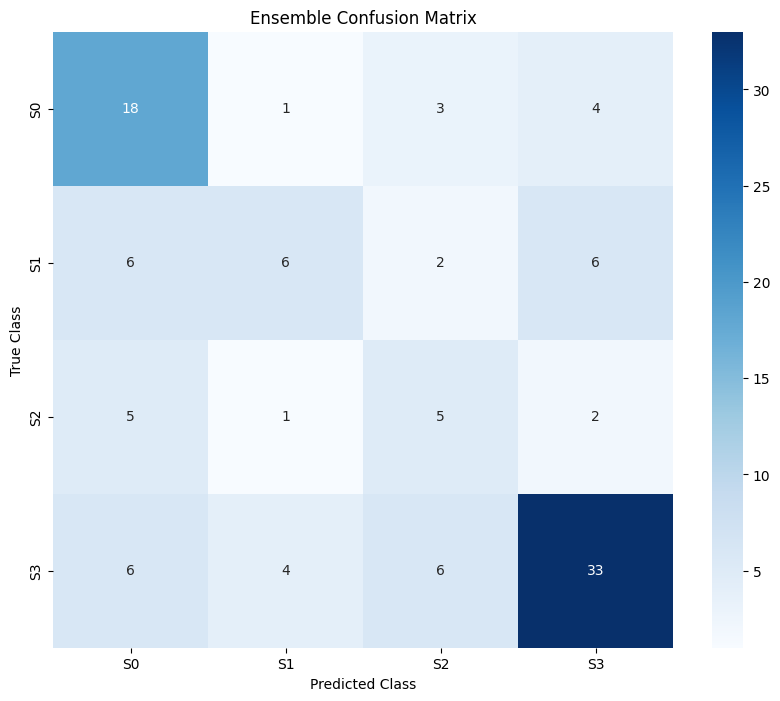


Model Agreement:
  2/5 models agree: 5 samples
  3/5 models agree: 58 samples
  4/5 models agree: 38 samples
  5/5 models agree: 7 samples


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION & SETUP
# ============================================================================
DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8
BATCH_SIZE = 4
EPOCHS = 100
PATIENCE = 15
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# Set random seeds
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# ============================================================================
# DATASET CLASS
# ============================================================================
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================
class PancreasTransformer(nn.Module):
    def __init__(self, unfreeze_blocks=True):
        super().__init__()
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        for param in backbone.parameters():
            param.requires_grad = False
            
        if unfreeze_blocks:
            for name, param in backbone.named_parameters():
                if "blocks.6" in name or "blocks.7" in name:
                    param.requires_grad = True
                    
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=1280, 
            nhead=4, 
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1)
        return self.classifier(x)

# ============================================================================
# DATA PREPARATION
# ============================================================================
print("\n" + "="*80)
print("DATA LOADING PHASE")
print("="*80)

all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = [f for f in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, f))]
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print(f"\nTotal samples: {len(all_paths)}")

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================================================================
# K-FOLD TRAINING
# ============================================================================
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\nFOLD {fold+1}/{FOLDS}")
    
    train_p, val_p = all_paths[train_idx], all_paths[val_idx]
    train_l, val_l = all_labels[train_idx], all_labels[val_idx]
    
    train_loader = DataLoader(PancreasDataset(train_p, train_l, train_tfms, True), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(PancreasDataset(val_p, val_l, val_tfms, False), batch_size=BATCH_SIZE)
    
    model = PancreasTransformer(unfreeze_blocks=True).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 2.5, 4.0, 1.0]).to(DEVICE))
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                val_loss += criterion(model(imgs), lbls).item()
        
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break
            
    model.load_state_dict(best_state)
    fold_models.append(model)

# ============================================================================
# ENSEMBLE EVALUATION (FIXED)
# ============================================================================
def predict_with_ensemble(paths, labels):
    all_probs = []
    
    for model in fold_models:
        model.eval()
        fold_probs = []
        with torch.no_grad():
            for path in paths:
                # Basic TTA: Original + Horizontal Flip
                img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg'))])[:MAX_SEQ_LENGTH]
                seq = [val_tfms(Image.open(os.path.join(path, f)).convert('RGB')) for f in img_names]
                while len(seq) < MAX_SEQ_LENGTH: seq.append(torch.zeros_like(seq[0]))
                
                inp = torch.stack(seq).unsqueeze(0).to(DEVICE)
                out = torch.softmax(model(inp), dim=1).cpu().numpy()
                fold_probs.append(out[0])
        all_probs.append(np.array(fold_probs))
    
    # Average probabilities across folds
    ensemble_probs = np.mean(all_probs, axis=0)
    
    # FIXED: Use axis=1 to get the predicted class for each of the 108 samples
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    
    # Calculate Agreement
    agreements = []
    for i in range(len(paths)):
        sample_preds = [np.argmax(all_probs[f][i]) for f in range(FOLDS)]
        most_common = max(set(sample_preds), key=sample_preds.count)
        agreements.append(sample_preds.count(most_common))
        
    return ensemble_preds, ensemble_probs, np.max(ensemble_probs, axis=1), agreements

# Run evaluation
preds, probs, confidence, agreement = predict_with_ensemble(all_paths, all_labels)

# ============================================================================
# RESULTS & CONFUSION MATRIX
# ============================================================================
print("\n" + "="*80)
print("FINAL ENSEMBLE RESULTS")
print("="*80)

accuracy = accuracy_score(all_labels, preds)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, preds, target_names=CLASSES))

# Confusion Matrix Visualization
cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Ensemble Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Agreement stats
unique, counts = np.unique(agreement, return_counts=True)
print("\nModel Agreement:")
for u, c in zip(unique, counts):
    print(f"  {u}/5 models agree: {c} samples")

# # no of epochs = 60


--- FOLD 1 ---
Fold 1 Best Val Loss: 1.3235

--- FOLD 2 ---
Fold 2 Best Val Loss: 1.3441

--- FOLD 3 ---
Fold 3 Best Val Loss: 1.3423

--- FOLD 4 ---
Fold 4 Best Val Loss: 1.2775

--- FOLD 5 ---
Fold 5 Best Val Loss: 1.3010

ENSEMBLE METRICS (MAX-POOLING STRATEGY)
Accuracy: 0.8148
              precision    recall  f1-score   support

          S0       0.92      0.88      0.90        26
          S1       0.57      0.85      0.68        20
          S2       0.93      1.00      0.96        13
          S3       0.90      0.71      0.80        49

    accuracy                           0.81       108
   macro avg       0.83      0.86      0.84       108
weighted avg       0.85      0.81      0.82       108



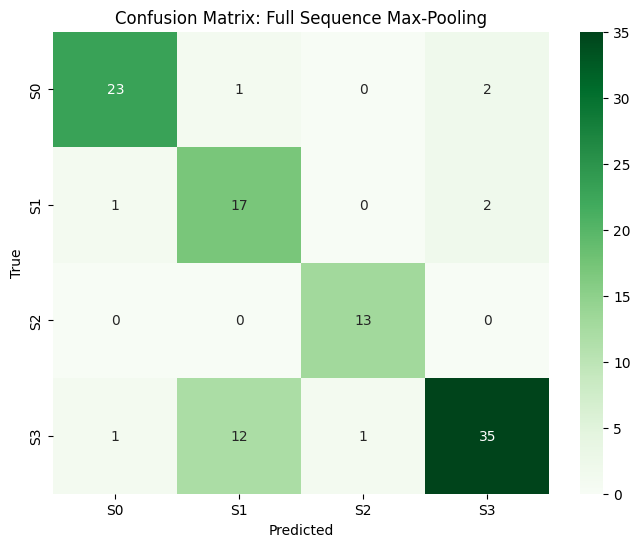

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
# We no longer limit to 8; we process what's available
BATCH_SIZE = 1 # Keep small because sequences can be long
EPOCHS = 60
PATIENCE = 10
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================================
# DATASET: Load ALL images in a folder
# ============================================================================
class PancreasFullSequenceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        # Get all valid images in folder
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        sequence = []
        for name in img_names:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
        
        # Convert list of tensors to (Seq_Len, 3, 224, 224)
        return torch.stack(sequence), label

# ============================================================================
# MODEL: EfficientNet + Global Max Pooling
# ============================================================================
class PancreasPoolingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Using EfficientNet-B0
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        # x shape: (1, Seq_Len, 3, 224, 224) -> Batch size is 1 for varying lengths
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        
        # Extract features: (Batch*Seq, 1280, 1, 1)
        features = self.feature_extractor(x)
        features = features.view(batch, seq, 1280)
        
        # GLOBAL MAX POOLING: Pick the strongest signal across the sequence
        # This finds the "most diseased" looking frame in the whole scan
        pooled, _ = torch.max(features, dim=1) 
        
        return self.classifier(pooled)

# ============================================================================
# DATA PREPARATION
# ============================================================================
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = [f for f in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, f))]
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================================================================
# K-FOLD TRAINING
# ============================================================================
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_models = []



for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- FOLD {fold+1} ---")
    
    train_p, val_p = all_paths[train_idx], all_paths[val_idx]
    train_l, val_l = all_labels[train_idx], all_labels[val_idx]
    
    # CALCULATE WEIGHTS FOR BALANCED SAMPLING
    class_sample_count = np.array([len(np.where(train_l == t)[0]) for t in np.unique(train_l)])
    weight = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weight[t] for t in train_l])).double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    
    train_loader = DataLoader(PancreasFullSequenceDataset(train_p, train_l, train_tfms), 
                              batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(PancreasFullSequenceDataset(val_p, val_l, val_tfms), 
                            batch_size=BATCH_SIZE)
    
    model = PancreasPoolingModel().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                v_loss += criterion(model(imgs), lbls).item()
        
        avg_v = v_loss/len(val_loader)
        if avg_v < best_val_loss:
            best_val_loss = avg_v
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break
            
    model.load_state_dict(best_state)
    fold_models.append(model)
    print(f"Fold {fold+1} Best Val Loss: {best_val_loss:.4f}")

# ============================================================================
# FINAL EVALUATION
# ============================================================================
def final_predict():
    all_preds = []
    model.eval()
    with torch.no_grad():
        for path in all_paths:
            # Process sequence
            img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg'))])
            seq = [val_tfms(Image.open(os.path.join(path, f)).convert('RGB')) for f in img_names]
            inp = torch.stack(seq).unsqueeze(0).to(DEVICE)
            
            # Ensemble voting
            fold_outputs = []
            for m in fold_models:
                fold_outputs.append(torch.softmax(m(inp), dim=1).cpu().numpy())
            
            avg_prob = np.mean(fold_outputs, axis=0)
            all_preds.append(np.argmax(avg_prob, axis=1)[0])
    return np.array(all_preds)

preds = final_predict()

# ============================================================================
# METRICS & CONFUSION MATRIX
# ============================================================================
print("\n" + "="*30)
print("ENSEMBLE METRICS (MAX-POOLING STRATEGY)")
print("="*30)
print(f"Accuracy: {accuracy_score(all_labels, preds):.4f}")
print(classification_report(all_labels, preds, target_names=CLASSES))

cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix: Full Sequence Max-Pooling')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

------------------------------
Testing Folder: GF82276_20240514_10-44-50
Actual Label:    S1
Predicted Label: S1
Confidence:      70.98%
------------------------------


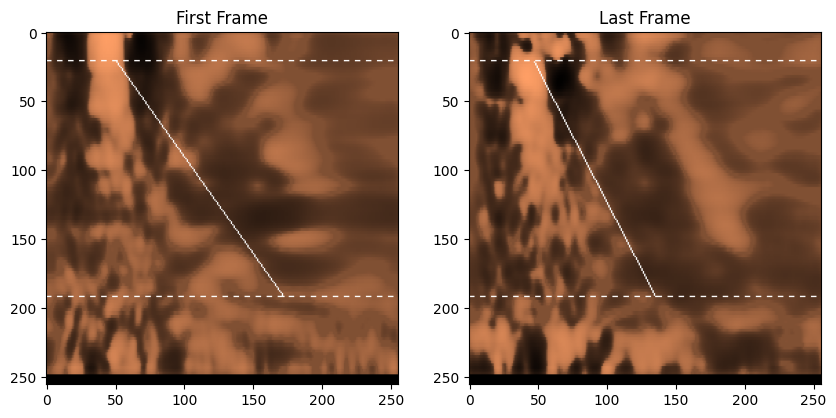

In [10]:
def test_single_patient(folder_path, true_label_name=None):
    """
    Predicts the stage for a single folder (patient)
    """
    model.eval()
    
    # 1. Load and Preprocess all images in the folder
    img_names = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if not img_names:
        print("No images found in this folder!")
        return

    sequence = []
    for name in img_names:
        img = Image.open(os.path.join(folder_path, name)).convert('RGB')
        sequence.append(val_tfms(img))
    
    # Shape: (1, Seq_Len, 3, 224, 224)
    input_tensor = torch.stack(sequence).unsqueeze(0).to(DEVICE)

    # 2. Get Ensemble Prediction
    all_fold_probs = []
    with torch.no_grad():
        for m in fold_models:
            logits = m(input_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_fold_probs.append(probs)
    
    # Average the probabilities across the 5 folds
    avg_probs = np.mean(all_fold_probs, axis=0)[0]
    pred_idx = np.argmax(avg_probs)
    confidence = avg_probs[pred_idx] * 100

    # 3. Print Results
    print("-" * 30)
    print(f"Testing Folder: {os.path.basename(folder_path)}")
    if true_label_name:
        print(f"Actual Label:    {true_label_name}")
    print(f"Predicted Label: {CLASSES[pred_idx]}")
    print(f"Confidence:      {confidence:.2f}%")
    print("-" * 30)

    # Optional: Display the first and last image of the sequence
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(Image.open(os.path.join(folder_path, img_names[0])))
    ax[0].set_title("First Frame")
    ax[1].imshow(Image.open(os.path.join(folder_path, img_names[-1])))
    ax[1].set_title("Last Frame")
    plt.show()

# --- HOW TO USE IT ---
# Pick any folder from your S1 or S2 directory to see if it works!
my_test_folder = os.path.join(DATA_PATH, 'S1', 'GF82276_20240514_10-44-50') 
test_single_patient(my_test_folder, true_label_name='S1')

In [21]:
def test_specific_patient(patient_folder_path):
    """
    Tests the trained ensemble on a single patient folder.
    Args:
        patient_folder_path (str): Full path to the folder containing patient scans.
    """
    if not os.path.exists(patient_folder_path):
        print(f"Error: Folder '{patient_folder_path}' not found.")
        return

    # 1. Load and Preprocess the sequence
    img_names = sorted([f for f in os.listdir(patient_folder_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if not img_names:
        print("No images found in the folder.")
        return

    sequence = []
    for name in img_names:
        img = Image.open(os.path.join(patient_folder_path, name)).convert('RGB')
        img = val_tfms(img) # Using the validation transforms defined earlier
        sequence.append(img)
    
    # Shape: (1, Num_Images, 3, 224, 224)
    input_tensor = torch.stack(sequence).unsqueeze(0).to(DEVICE)

    # 2. Get predictions from all 5 fold models
    all_fold_probs = []
    
    print(f"\nAnalyzing patient: {os.path.basename(patient_folder_path)}")
    print("-" * 30)

    with torch.no_grad():
        for i, model in enumerate(fold_models):
            model.eval()
            output = model(input_tensor)
            prob = torch.softmax(output, dim=1).cpu().numpy()[0]
            all_fold_probs.append(prob)
            
            # Optional: print individual fold results
            # print(f"Fold {i+1} thinks: {CLASSES[np.argmax(prob)]} ({np.max(prob)*100:.1f}%)")

    # 3. Average the results (Ensemble Voting)
    avg_probs = np.mean(all_fold_probs, axis=0)
    final_class_idx = np.argmax(avg_probs)
    confidence = avg_probs[final_class_idx] * 100

    # 4. Display Result
    print(f"FINAL PREDICTION : {CLASSES[final_class_idx]}")
    print(f"CONFIDENCE       : {confidence:.2f}%")
    print("-" * 30)
    
    # Show class probability distribution
    for i, cls in enumerate(CLASSES):
        print(f"{cls}: {avg_probs[i]*100:6.2f}% " + "█" * int(avg_probs[i]*20))

# ==========================================
# EXAMPLE USAGE
# ==========================================
# Replace with a real folder path from your dataset
sample_folder = os.path.join(DATA_PATH, 'S2', 'GF82276_20240520_09-24-57')
test_specific_patient(sample_folder)


Analyzing patient: GF82276_20240520_09-24-57
------------------------------
FINAL PREDICTION : S2
CONFIDENCE       : 81.63%
------------------------------
S0:  11.27% ██
S1:   1.85% 
S2:  81.63% ████████████████
S3:   5.25% █


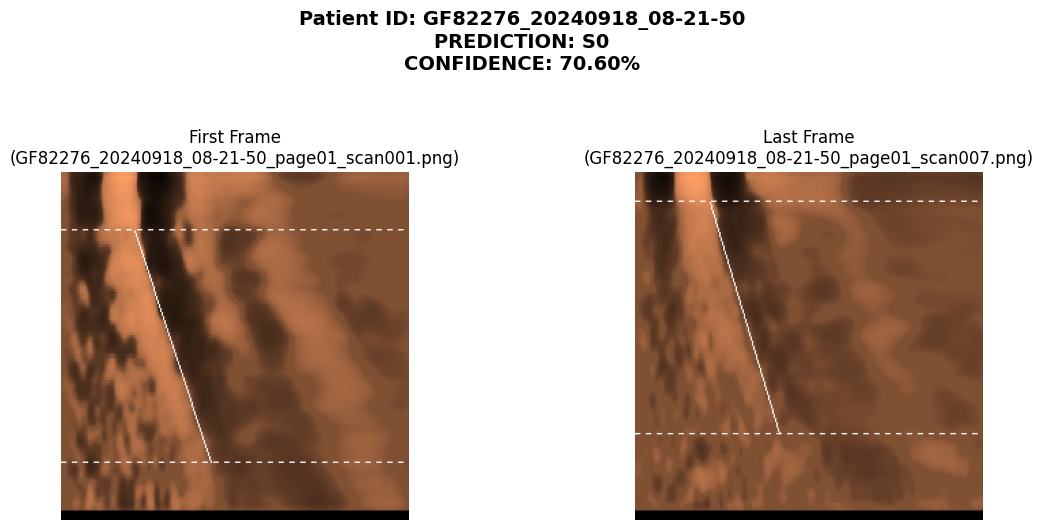


Probability Distribution:
S0:  70.60% ██████████████
S1:  11.54% ██
S2:   7.61% █
S3:  10.25% ██


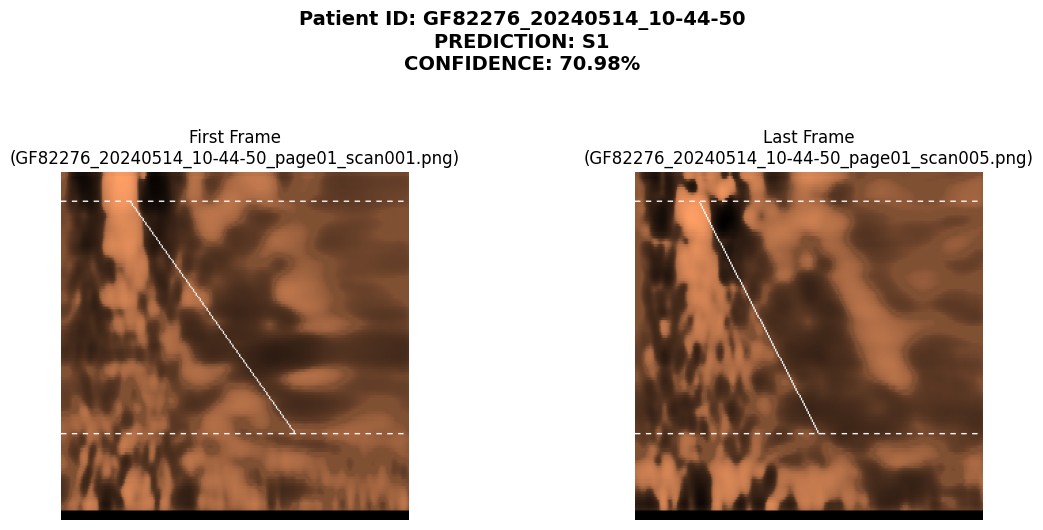


Probability Distribution:
S0:   5.56% █
S1:  70.98% ██████████████
S2:  13.11% ██
S3:  10.34% ██


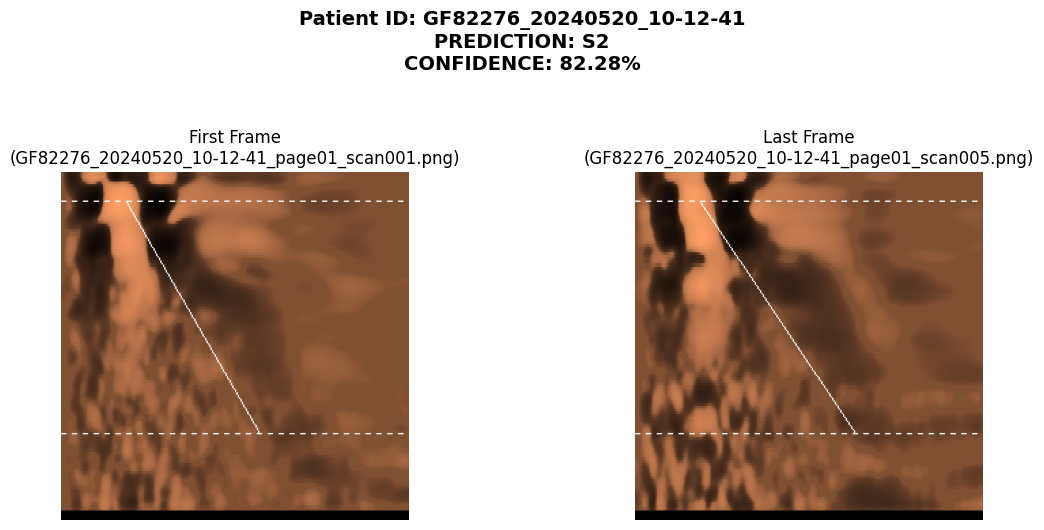


Probability Distribution:
S0:   4.26% 
S1:  11.63% ██
S2:  82.28% ████████████████
S3:   1.83% 


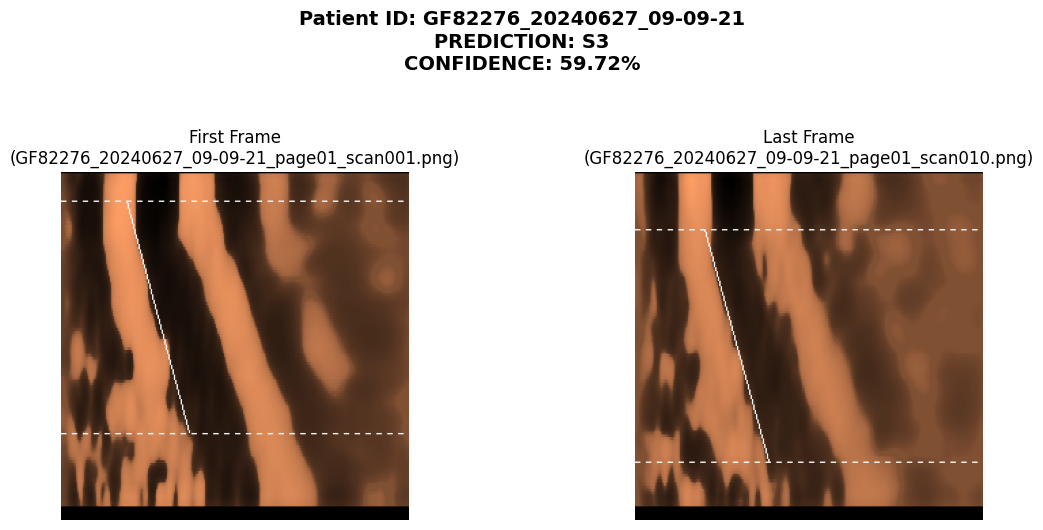


Probability Distribution:
S0:  13.40% ██
S1:  16.63% ███
S2:  10.25% ██
S3:  59.72% ███████████


In [22]:
def test_and_visualize_patient(patient_folder_path):
    """
    Predicts the category for a patient and plots the first and last frames.
    """
    if not os.path.exists(patient_folder_path):
        print(f"Error: Path {patient_folder_path} does not exist.")
        return

    # 1. Load Image Names
    img_names = sorted([f for f in os.listdir(patient_folder_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if len(img_names) < 2:
        print("Not enough images in folder to show first and last frames.")
        return

    # 2. Prepare Images for Model
    sequence = []
    for name in img_names:
        img = Image.open(os.path.join(patient_folder_path, name)).convert('RGB')
        sequence.append(val_tfms(img))
    
    input_tensor = torch.stack(sequence).unsqueeze(0).to(DEVICE)

    # 3. Ensemble Prediction
    all_fold_probs = []
    with torch.no_grad():
        for model in fold_models:
            model.eval()
            output = model(input_tensor)
            all_fold_probs.append(torch.softmax(output, dim=1).cpu().numpy()[0])
    
    avg_probs = np.mean(all_fold_probs, axis=0)
    pred_idx = np.argmax(avg_probs)
    confidence = avg_probs[pred_idx]

    # 4. Visualization (Plotting)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Load raw images for display (untransformed)
    first_img = Image.open(os.path.join(patient_folder_path, img_names[0]))
    last_img = Image.open(os.path.join(patient_folder_path, img_names[-1]))

    axes[0].imshow(first_img, cmap='gray' if 'gray' in str(first_img.mode).lower() else None)
    axes[0].set_title(f"First Frame\n({img_names[0]})")
    axes[0].axis('off')

    axes[1].imshow(last_img, cmap='gray' if 'gray' in str(last_img.mode).lower() else None)
    axes[1].set_title(f"Last Frame\n({img_names[-1]})")
    axes[1].axis('off')

    # Add result text to the plot
    result_text = (f"Patient ID: {os.path.basename(patient_folder_path)}\n"
                   f"PREDICTION: {CLASSES[pred_idx]}\n"
                   f"CONFIDENCE: {confidence*100:.2f}%")
    
    plt.suptitle(result_text, fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

    # 5. Print Detailed Probability Distribution
    print("\nProbability Distribution:")
    for i, cls in enumerate(CLASSES):
        bar = "█" * int(avg_probs[i] * 20)
        print(f"{cls:2s}: {avg_probs[i]*100:6.2f}% {bar}")

# ==========================================
# TEST ON ALL CATEGORIES
# ==========================================
# You can loop through one folder from each category to see how it performs
for category in CLASSES:
    cat_path = os.path.join(DATA_PATH, category)
    if os.path.exists(cat_path):
        sample_folder = next(os.path.join(cat_path, f) for f in os.listdir(cat_path) 
                            if os.path.isdir(os.path.join(cat_path, f)))
        test_and_visualize_patient(sample_folder)

# no of epochs = 80


--- FOLD 1 ---
Fold 1 Best Val Loss: 1.3278

--- FOLD 2 ---
Fold 2 Best Val Loss: 1.3313

--- FOLD 3 ---
Fold 3 Best Val Loss: 1.3457

--- FOLD 4 ---
Fold 4 Best Val Loss: 1.2515

--- FOLD 5 ---
Fold 5 Best Val Loss: 1.2844

ENSEMBLE METRICS (MAX-POOLING STRATEGY)
Accuracy: 0.8704
              precision    recall  f1-score   support

          S0       0.91      0.77      0.83        26
          S1       0.74      1.00      0.85        20
          S2       0.86      0.92      0.89        13
          S3       0.93      0.86      0.89        49

    accuracy                           0.87       108
   macro avg       0.86      0.89      0.87       108
weighted avg       0.88      0.87      0.87       108



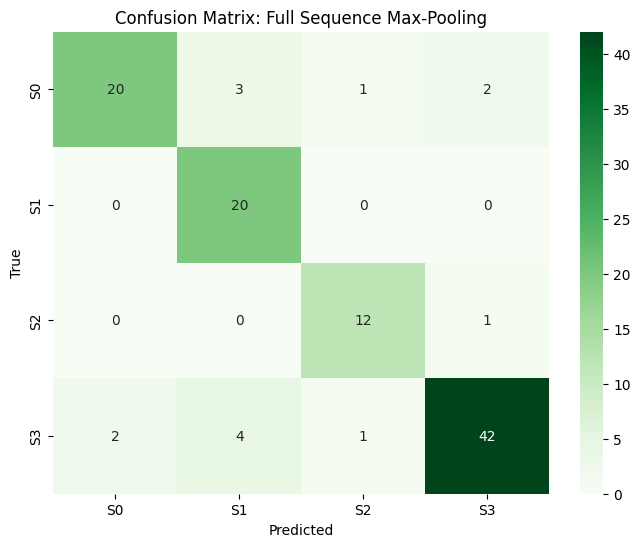

In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
# We no longer limit to 8; we process what's available
BATCH_SIZE = 1 # Keep small because sequences can be long
EPOCHS = 100
PATIENCE = 10
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================================
# DATASET: Load ALL images in a folder
# ============================================================================
class PancreasFullSequenceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        # Get all valid images in folder
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        sequence = []
        for name in img_names:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
        
        # Convert list of tensors to (Seq_Len, 3, 224, 224)
        return torch.stack(sequence), label

# ============================================================================
# MODEL: EfficientNet + Global Max Pooling
# ============================================================================
class PancreasPoolingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Using EfficientNet-B0
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        # x shape: (1, Seq_Len, 3, 224, 224) -> Batch size is 1 for varying lengths
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        
        # Extract features: (Batch*Seq, 1280, 1, 1)
        features = self.feature_extractor(x)
        features = features.view(batch, seq, 1280)
        
        # GLOBAL MAX POOLING: Pick the strongest signal across the sequence
        # This finds the "most diseased" looking frame in the whole scan
        pooled, _ = torch.max(features, dim=1) 
        
        return self.classifier(pooled)

# ============================================================================
# DATA PREPARATION
# ============================================================================
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = [f for f in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, f))]
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================================================================
# K-FOLD TRAINING
# ============================================================================
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_models = []



for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- FOLD {fold+1} ---")
    
    train_p, val_p = all_paths[train_idx], all_paths[val_idx]
    train_l, val_l = all_labels[train_idx], all_labels[val_idx]
    
    # CALCULATE WEIGHTS FOR BALANCED SAMPLING
    class_sample_count = np.array([len(np.where(train_l == t)[0]) for t in np.unique(train_l)])
    weight = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weight[t] for t in train_l])).double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    
    train_loader = DataLoader(PancreasFullSequenceDataset(train_p, train_l, train_tfms), 
                              batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(PancreasFullSequenceDataset(val_p, val_l, val_tfms), 
                            batch_size=BATCH_SIZE)
    
    model = PancreasPoolingModel().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                v_loss += criterion(model(imgs), lbls).item()
        
        avg_v = v_loss/len(val_loader)
        if avg_v < best_val_loss:
            best_val_loss = avg_v
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break
            
    model.load_state_dict(best_state)
    fold_models.append(model)
    print(f"Fold {fold+1} Best Val Loss: {best_val_loss:.4f}")

# ============================================================================
# FINAL EVALUATION
# ============================================================================
def final_predict():
    all_preds = []
    model.eval()
    with torch.no_grad():
        for path in all_paths:
            # Process sequence
            img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg'))])
            seq = [val_tfms(Image.open(os.path.join(path, f)).convert('RGB')) for f in img_names]
            inp = torch.stack(seq).unsqueeze(0).to(DEVICE)
            
            # Ensemble voting
            fold_outputs = []
            for m in fold_models:
                fold_outputs.append(torch.softmax(m(inp), dim=1).cpu().numpy())
            
            avg_prob = np.mean(fold_outputs, axis=0)
            all_preds.append(np.argmax(avg_prob, axis=1)[0])
    return np.array(all_preds)

preds = final_predict()

# ============================================================================
# METRICS & CONFUSION MATRIX
# ============================================================================
print("\n" + "="*30)
print("ENSEMBLE METRICS (MAX-POOLING STRATEGY)")
print("="*30)
print(f"Accuracy: {accuracy_score(all_labels, preds):.4f}")
print(classification_report(all_labels, preds, target_names=CLASSES))

cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix: Full Sequence Max-Pooling')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# no of epochs = 120


--- FOLD 1 ---
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


Fold 1 Best Val Loss: 1.3230

--- FOLD 2 ---
Fold 2 Best Val Loss: 1.3498

--- FOLD 3 ---
Fold 3 Best Val Loss: 1.3426

--- FOLD 4 ---
Fold 4 Best Val Loss: 1.0898

--- FOLD 5 ---
Fold 5 Best Val Loss: 1.3149

ENSEMBLE METRICS (MAX-POOLING STRATEGY)
Accuracy: 0.8056
              precision    recall  f1-score   support

          S0       0.72      0.88      0.79        26
          S1       0.73      0.80      0.76        20
          S2       0.87      1.00      0.93        13
          S3       0.90      0.71      0.80        49

    accuracy                           0.81       108
   macro avg       0.80      0.85      0.82       108
weighted avg       0.82      0.81      0.80       108



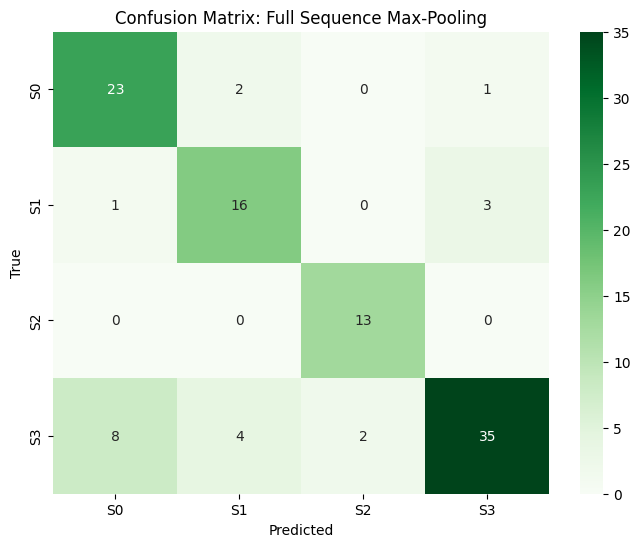

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
DATA_PATH = '/kaggle/input/datasets/ayaosama21/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
# We no longer limit to 8; we process what's available
BATCH_SIZE = 1 # Keep small because sequences can be long
EPOCHS = 120
PATIENCE = 10
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================================
# DATASET: Load ALL images in a folder
# ============================================================================
class PancreasFullSequenceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        # Get all valid images in folder
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        sequence = []
        for name in img_names:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
        
        # Convert list of tensors to (Seq_Len, 3, 224, 224)
        return torch.stack(sequence), label

# ============================================================================
# MODEL: EfficientNet + Global Max Pooling
# ============================================================================
class PancreasPoolingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Using EfficientNet-B0
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        # x shape: (1, Seq_Len, 3, 224, 224) -> Batch size is 1 for varying lengths
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        
        # Extract features: (Batch*Seq, 1280, 1, 1)
        features = self.feature_extractor(x)
        features = features.view(batch, seq, 1280)
        
        # GLOBAL MAX POOLING: Pick the strongest signal across the sequence
        # This finds the "most diseased" looking frame in the whole scan
        pooled, _ = torch.max(features, dim=1) 
        
        return self.classifier(pooled)

# ============================================================================
# DATA PREPARATION
# ============================================================================
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = [f for f in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, f))]
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================================================================
# K-FOLD TRAINING
# ============================================================================
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_models = []



for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- FOLD {fold+1} ---")
    
    train_p, val_p = all_paths[train_idx], all_paths[val_idx]
    train_l, val_l = all_labels[train_idx], all_labels[val_idx]
    
    # CALCULATE WEIGHTS FOR BALANCED SAMPLING
    class_sample_count = np.array([len(np.where(train_l == t)[0]) for t in np.unique(train_l)])
    weight = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weight[t] for t in train_l])).double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    
    train_loader = DataLoader(PancreasFullSequenceDataset(train_p, train_l, train_tfms), 
                              batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(PancreasFullSequenceDataset(val_p, val_l, val_tfms), 
                            batch_size=BATCH_SIZE)
    
    model = PancreasPoolingModel().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                v_loss += criterion(model(imgs), lbls).item()
        
        avg_v = v_loss/len(val_loader)
        if avg_v < best_val_loss:
            best_val_loss = avg_v
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break
            
    model.load_state_dict(best_state)
    fold_models.append(model)
    print(f"Fold {fold+1} Best Val Loss: {best_val_loss:.4f}")

# ============================================================================
# FINAL EVALUATION
# ============================================================================
def final_predict():
    all_preds = []
    model.eval()
    with torch.no_grad():
        for path in all_paths:
            # Process sequence
            img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg'))])
            seq = [val_tfms(Image.open(os.path.join(path, f)).convert('RGB')) for f in img_names]
            inp = torch.stack(seq).unsqueeze(0).to(DEVICE)
            
            # Ensemble voting
            fold_outputs = []
            for m in fold_models:
                fold_outputs.append(torch.softmax(m(inp), dim=1).cpu().numpy())
            
            avg_prob = np.mean(fold_outputs, axis=0)
            all_preds.append(np.argmax(avg_prob, axis=1)[0])
    return np.array(all_preds)

preds = final_predict()

# ============================================================================
# METRICS & CONFUSION MATRIX
# ============================================================================
print("\n" + "="*30)
print("ENSEMBLE METRICS (MAX-POOLING STRATEGY)")
print("="*30)
print(f"Accuracy: {accuracy_score(all_labels, preds):.4f}")
print(classification_report(all_labels, preds, target_names=CLASSES))

cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix: Full Sequence Max-Pooling')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()